In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [82]:
"""
Common Functions
You are not expected to modify these
"""
_bits = []
for i in range(256):
    bs = bin(i)[2:].rjust(8,'0')
    _bits.append(np.array([float(v) for v in bs]))

def read_img(path):
    """Read image."""
    image = cv2.imread(path, cv2.COLOR_BGR2RGB)
    return image

def save_img(img, path):
    """Save image."""
    cv2.imwrite(path, img)

# note this is different than in previous homeworks
def show_img(image, *args, **kwargs):
    if len(image.shape) == 2:
      # Height, width - must be grayscale
      # convert to RGB, since matplotlib will plot in a weird colormap (instead of black = 0, white = 1)
      image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Draw the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    plt.show()

def homography_transform(X, H):
    '''
    Perform homography transformation on a set of points X
    using homography matrix H

    Input - X: a set of 2D points in an array with size (N,2)
            H: a 3*3 homography matrix
    Output -Y: a set of 2D points in an array with size (N,2)
    '''
    X_homogeneous = np.hstack([X,np.ones((X.shape[0],1))])
    Y = np.dot(H,X_homogeneous.T).T
    return Y[:,:2] / Y[:,2][:,None]

def get_match_points(kp1, kp2, matches):
    '''
    Returns list of paired keypoint locations

    Input - kp1: Keypoint matrix 1 of shape (N,4)
            kp2: Keypoint matrix 1 of shape (M,4)
            matches: List of matching pairs indices between the 2 sets of keypoints (K,2)

    Output - An array of shape (K,4) where row i contains pixel locations corresponding
             to a matched keypoint in the 2 images : [img1_x, img1_y, img2_x, img2_y]
    '''
    return np.hstack([kp1[matches[:,0],:2], kp2[matches[:,1],:2]])

def kps_to_matrix(kps):
    '''
    Converts cv2 container of keypoint locations into numpy array

    Input - kps: opencv container of keypoints location

    Output - K: A numpy Keypoint matrix of shape (N,4)
    '''
    K = np.zeros((len(kps),4))
    for i in range(len(kps)):
        K[i,:2] = kps[i].pt
        K[i,2] = kps[i].angle
        K[i,3] = kps[i].octave
    return K

def expand_binarize(desc):
    '''
    Explicitly expand packed binary keypoint descriptors like AKAZE and ORB.
    You do not need to modify or worry about this.

    AKAZE and ORB return a descriptor that is binary. Usually one compares
    descriptors using the hamming distance (# of bits that differ). This is
    usually fast since one can do this with binary operators. On Intel
    processors, there's an instruction for this: popcnt/population count.

    On the other hand, this prevents you from actually implementing all the steps
    of the pipeline and requires you writing a hamming distance. So instead, we
    explicitly expand the feature from F packed binary uint8s to (8F) explicit
    binary 0 or 1 descriptors. The square of the L2 distance of these
    descriptors is the hamming distance.

    Converts a matrix where each row is a vector containing F uint8s into their
    explicit binary form.

    Input - desc: matrix of size (N,F) containing N 8F dimensional binary
                  descriptors packed into N, F dimensional uint8s

    Output - binary_desc: matrix of size (N,8F) containing only 0s or 1s that
                          expands this to be explicit
    '''
    N, F = desc.shape
    binary_desc = np.zeros((N,F*8))
    for i in range(N):
        for j in range(F):
            binary_desc[i,(j*8):((j+1)*8)] = _bits[desc[i,j]]
    return binary_desc

def get_AKAZE(I):
    '''
    Extracts AKAZE keypoints and descriptors from an image

    Input - img: Input image of shape (H,W,3)

    Output - kps: (K,4) matrix where each row is [x,y,angle,octave]
             desc: (K,1024) matrix of AKAZE descriptors expanded to be
                   comparable using squared L2 distance
    '''
    akaze = cv2.AKAZE_create()
    kps, D = akaze.detectAndCompute(I, None)
    return kps_to_matrix(kps), expand_binarize(D).astype(np.float32)


def visualize_keypoints(I1, I2, kps1, kps2):
    '''
    Visualize keypoints between the two input images

    Input - I1: Input image 1 of shape (H1,W1,3)
    Input - I1: Input image 1 of shape (H1,W1,3)
    Input - kps1: (K,4) matrix where each row is [x,y,angle,octave]
    Input - kps2: (K,4) matrix where each row is [x,y,angle,octave]
    '''
    gap = 100
    concat_image = np.hstack((I1, np.zeros((I1.shape[0], gap, I1.shape[-1]), dtype=np.uint8), I2))
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.set_title('Keypoints')
    ax.imshow(concat_image)

    kps2[:,0] = kps2[:,0] + I1.shape[1] + gap
    merged_kps = np.vstack((kps1, kps2))
    octaves = np.unique(merged_kps[:,3])
    octave_colors = ['r', 'b', 'g', 'y', 'w', 'c', 'm']
    octave_markers = ['o', 'x', '+', '*']
    octave_marker_size = [40, 20, 10]
    for idx, o in enumerate(octaves):
        merged_kps_o = merged_kps[merged_kps[:,3]==o]
        ax.scatter(merged_kps[:,0], merged_kps[:,1],
                   c=octave_colors[idx],
                   marker=octave_markers[idx],
                   s=octave_marker_size[idx]
        )

    ax.axis('off')
    plt.show()

In [63]:
plt.subplots??

In [ ]:
"""
Homography fitting functions
You should write these
"""

def fit_homography(XY):
    '''
    Given a set of N correspondences XY of the form [x,y,x',y'],
    fit a homography from [x,y,1] to [x',y',1].

    Input - XY: an array with size(N,4), each row contains two
            points in the form [x_i, y_i, x'_i, y'_i] (1,4)
    Output -H: a (3,3) homography matrix that (if the correspondences can be
            described by a homography) satisfies [x',y',1]^T === H [x,y,1]^T

    '''
    H = None


    # U,S,V = np.linalg.svd(A)
    # H = V[-1,:].reshape(3,3)
    # H = H/H[2,2]

    return H


def RANSAC_fit_homography(XY, eps=1, nIters=1000):
    '''
    Perform RANSAC to find the homography transformation
    matrix which has the most inliers

    Input - XY: an array with size(N,4), each row contains two
            points in the form [x_i, y_i, x'_i, y'_i] (1,4)
            eps: threshold distance for inlier calculation
            nIters: number of iteration for running RANSAC
    Output - bestH: a (3,3) homography matrix fit to the
                    inliers from the best model.

    Hints:
    a) Sample without replacement. Otherwise you risk picking a set of points
       that have a duplicate.
    b) *Re-fit* the homography after you have found the best inliers
    '''
    bestH, bestCount, bestInliers = np.eye(3), -1, np.zeros((XY.shape[0],))
    bestRefit = np.eye(3)


    return bestRefit

points_case_1.npy
points_case_2.npy
points_case_3.npy
points_case_4.npy
points_case_5.npy
points_case_6.npy
points_case_7.npy
points_case_8.npy
points_case_9.npy


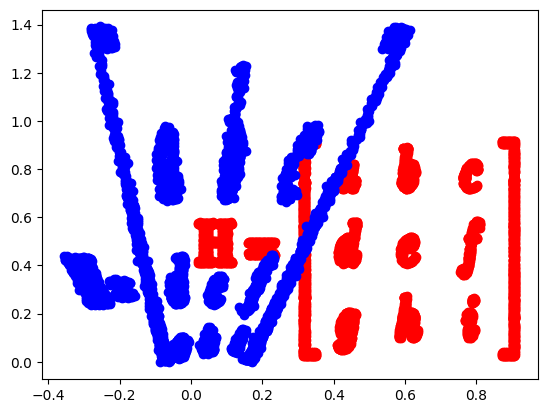

In [59]:
# Homography Fitting script

rootpath = "hdata"
dir = os.listdir(rootpath)
# alphabetize
dir.sort()

# use for file in dir[2] to work on the third file only
for file in dir:
  # fit homography using RANSAC

  print(file)
  points = np.load(file=os.path.join(rootpath,file))
p1, p2 = points[:,:2], points[:,2:]
plt.scatter(p1[:,0],p1[:,1],c='r',marker='o')
plt.scatter(p2[:,0],p2[:,1],c='b',marker='o')
plt.show()

  # 1. load points X from homography_data

  # 2. fit a homography

  # 3. transform the points

  # 4. plot the original points and transformed points

  # 5. compute average residual (pixel error per point)


In [5]:
"""
Image Stitching Functions
"""
def bilinear(image, row, col):
    """
    Return the interpolated value for row, col in image.
    Do not assume rol, col are in bounds.
    They must be non-negative and less than the width and height of image -1

    Input- image: H x W
    row, col: floating point scalar
    Output - value: scalar
    """
    value = None

    return value


def compute_distance(desc1, desc2):
    '''
    Calculates L2 distance between 2 binary descriptor vectors.

    Input - desc1: Descriptor vector of shape (N,F)
            desc2: Descriptor vector of shape (M,F)

    Output - dist: a (N,M) L2 distance matrix where dist(i,j)
             is the squared Euclidean distance between row i of
             desc1 and desc2. You may want to use the distance
             calculation trick
             ||x - y||^2 = ||x||^2 + ||y||^2 - 2x^T y
    '''
    dist = None

    return dist

def find_matches(desc1, desc2, ratioThreshold):
    '''
    Calculates the matches between the two sets of keypoint
    descriptors based on distance and ratio test.

    Input - desc1: Descriptor vector of shape (N,F)
            desc2: Descriptor vector of shape (M,F)
            ratioThreshhold : maximum acceptable distance ratio between 2
                              nearest matches

    Output - matches: a list of indices (i,j) 1 <= i <= N, 1 <= j <= M giving
             the matches between desc1 and desc2.

             This should be of size (K,2) where K is the number of
             matches and the row [ii,jj] should appear if desc1[ii,:] and
             desc2[jj,:] match.
    '''
    matches = []

    return matches

def draw_matches(img1, img2, kp1, kp2, matches):
    '''
    Creates an output image where the two source images stacked vertically
    connecting matching keypoints with a line.

    Input - img1: Input image 1 of shape (H1,W1,3)
            img2: Input image 2 of shape (H2,W2,3)
            kp1: Keypoint matrix for image 1 of shape (N,4)
            kp2: Keypoint matrix for image 2 of shape (M,4)
            matches: List of matching pairs indices between the 2 sets of
                     keypoints (K,2)

    Output - Image where 2 input images stacked vertically with lines joining
             the matched keypoints
    Hints!!:
    1) see cv2.line
    2) Use get_match_points() from the common functions box above
    to extract keypoint locations
    3) RGB values can be integers between 0 and 255 or floats between 0 and 1
    (floats between 0 and 255 don't work)
    '''

    output = None

    return output


def warp_and_combine(img1, img2, H):
    '''
    Merges the two images together given the two images and a homography:
    once you have the homography you do not need the correspondences any more.

    Input - img1: Input image 1 of shape (H1,W1,3)
            img2: Input image 2 of shape (H2,W2,3)
            H: homography mapping from img1 to img2
    Output - V: stitched image of size (?,?,3); unknown since it depends on H
    '''
    V = None

    return V


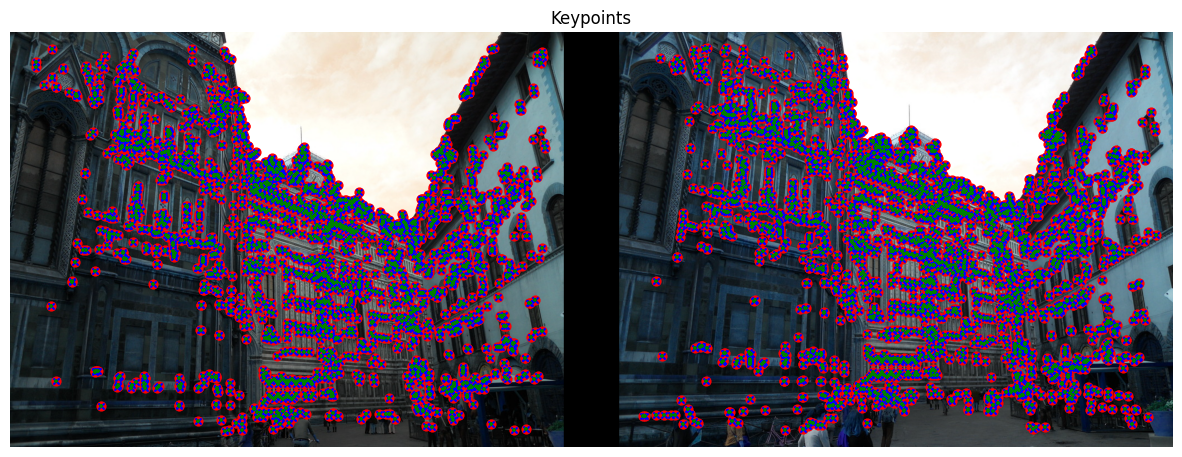

In [83]:
# Image Stitching Script - Part I

# You might want to loop over all image sets, but this takes time
# so you can specify one set at a time
rootpath = ""
to_stitch = 'stitch/florence2'
I1 = read_img(os.path.join(rootpath,to_stitch,'p1.jpg'))
I2 = read_img(os.path.join(rootpath,to_stitch,'p2.jpg'))

# Step 1: obtain keypoint locations and descriptors for each image separately

# visualize keypoints on at least one of the images
k1, matches_1 = get_AKAZE(I1)
k2, matches_2 = get_AKAZE(I2)
visualize_keypoints(I1, I2, k1, k2)


# Step 2: detect putative correspondences

# the above is the slowest step
# continue in new box


(array([1592,  324,   34]), array([1917,  352,   29]))

In [ ]:
# Image Stitching Script - Part II
# Maintain this split. You will thank me later.

# draw matches

# Step 3: RANSAC for homography fitting

# Step 4: stitching the images
# Be careful about the final image size
# all pixels of warped image must be included
# when both images map to a pixel of the output, picking either one is fine
# (no need to blend)
